In [1]:
from Project_utils import *

import numpy as np
from scipy.special import logsumexp

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns

import os
import warnings
warnings.simplefilter("ignore")
%matplotlib notebook

<img src="figures/formula.png">

In [16]:
def post_probability_HIT(x):
    """
    Defines likelihood/post probability functions
    :param x: 2D random vector
    :return: log likelihood
    """
    H_1 = -0.5 * ((x[0] + 11) ** 2) / (signoise ** 2) + np.log(0 <= x[1] < 2)
    H_2 = -0.5 * ((x[1] - 1) ** 2) / (signoise ** 2) + np.log(-11 <= x[0] < -9)
    H_3 = -0.5 * ((x[0] + 9) ** 2) / (signoise ** 2) + np.log(0 <= x[1] < 2)
    I_1= -0.5 * ((x[1] - 2) ** 2) / (signoise ** 2) + np.log(-7.5 <= x[0] < -6.5)
    I_2 = -0.5 * ((x[0] + 7) ** 2) / (signoise ** 2) + np.log(0 <= x[1] < 2)
    I_3 = -0.5 * ((x[1]) ** 2) / (signoise ** 2) + np.log(-8 <= x[0] < -6)
    T_1 = -0.5 * ((x[1] - 2) ** 2) / (signoise ** 2) + np.log(-5 <= x[0] < -3)
    T_2 = -0.5 * ((x[0] + 4) ** 2) / (signoise ** 2) + np.log(0 <= x[1] < 2)
    heart = -0.5 * ((x[1] - np.power(np.abs(x[0]),2/3) - 0.5)**2 + x[0]**2 - 1.5)**2 / (10*signoise ** 2)
    I = -0.5 * ((x[0] - 4) ** 2) / (signoise ** 2) + np.log(0 <= x[1] < 2)
    O1 = -0.5 * (((x[0] - 7) ** 2 + (x[1] - 1) ** 2 - 1.0) ** 2) / (signoise ** 2)
    O2 = -0.5 * (((x[0] - 10) ** 2 + (x[1] - 1) ** 2 - 1.0) ** 2) / (signoise ** 2)
    return logsumexp([H_1, H_2, H_3, I_1, I_2, I_3, T_1, T_2, heart, I, O1, O2])

## verify the graphic represented by post_probability_HIT function

In [13]:
x = np.arange(-13, 13, 0.1)
y = np.arange(3, -1, -0.1)
xx, yy = np.meshgrid(x, y)
val = []
for j in y:
    for i in x:
        val.append(np.exp(post_probability_HIT([i,j])))
val = np.array(val).reshape(xx.shape)

<IPython.core.display.Javascript object>


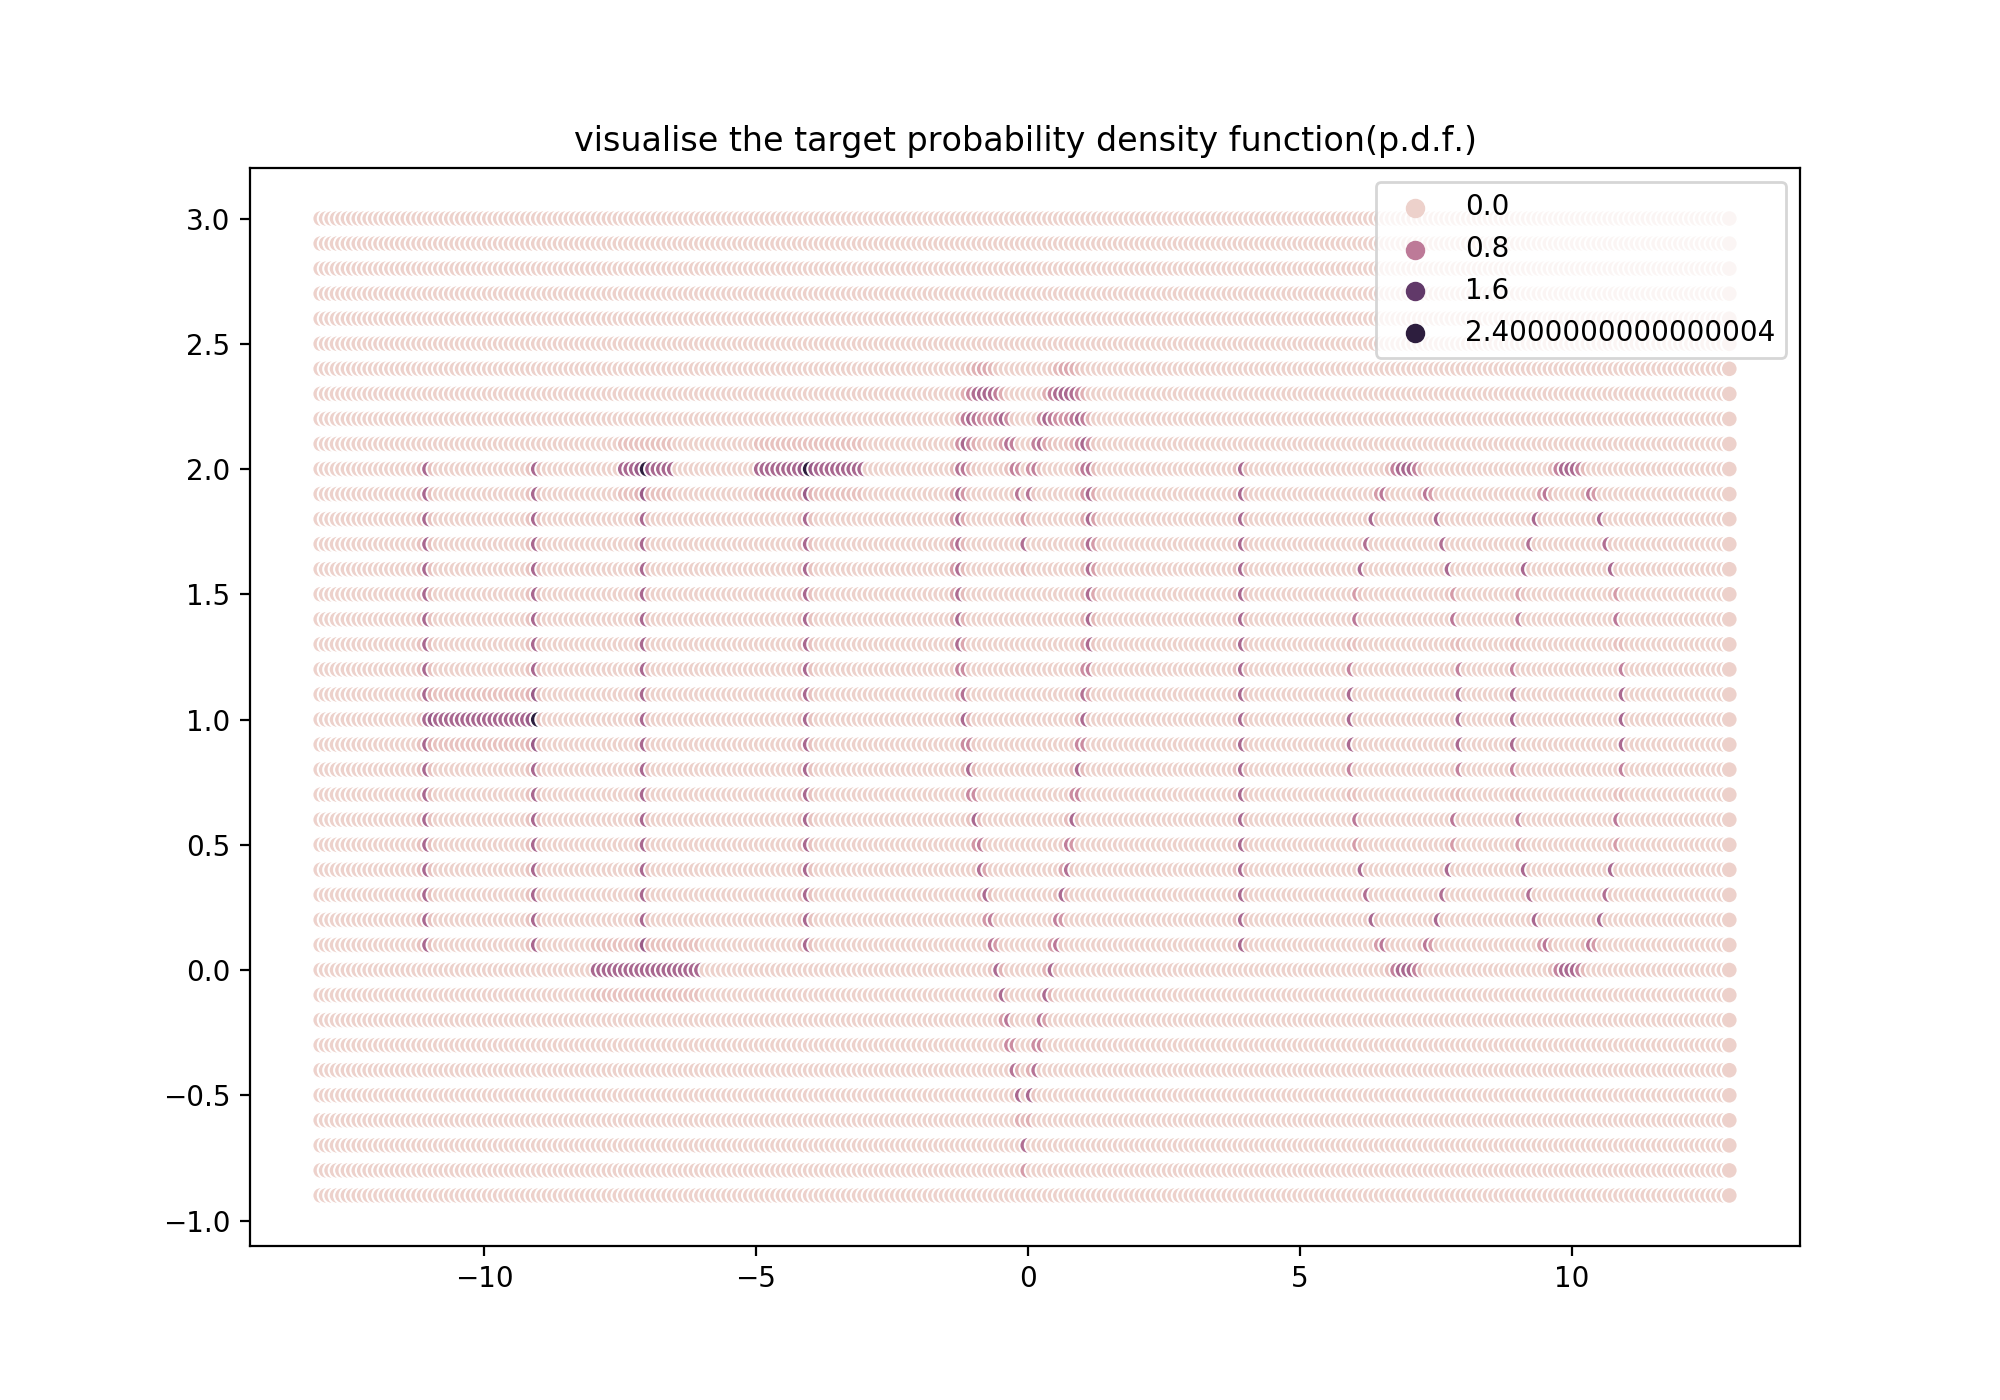

Text(0.5, 1.0, 'visualise the target probability density function(p.d.f.)')

In [15]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(1, 1, 1)
sns.scatterplot(x=xx.ravel(), y=yy.ravel(), hue=val.ravel())
ax.set_title("visualise the target probability density function(p.d.f.)")

## do experiment, generate the data for visualisation

In [17]:
D = 2
K = 5
N = 12000
p = [lambda loc: st.multivariate_normal.rvs(mean=loc, cov=np.array([[3, 0], [0, 0.5]]))] * K
u0 = st.uniform(loc=np.array([0, 0]), scale=np.array([11, 2])).rvs
Ns = 1
T_factor = 100
# !!Here to inject your own target p.d.f. !!
u = [lambda x, T=k: np.exp(post_probability_HIT(x) / T_factor ** T) for k in range(K)]
experiment_control = ParallelTempering(D, K, N, p, u, u0, Ns, alpha_opt = 0.234)
file_simplePT_name = 'data/hit100/simplePT_hit.obj'
if not os.path.exists(os.path.dirname(file_simplePT_name)):
    os.makedirs(os.path.dirname(file_simplePT_name))


val = input('Enter "y" to read data from disk, "n" to regenerate data\n')
if val == 'n':
    # generate data from Markov Chain
    _, acc = experiment_control.generateMarkovChain(mode='simple PT')
    experiment_control.save(file_simplePT_name)
else:
    # load data from disk
    experiment_control.load(file_simple_name)


Enter "y" to read data from disk, "n" to regenerate data
n


## visualise generated random number(vector) by histgram and animation

<IPython.core.display.Javascript object>


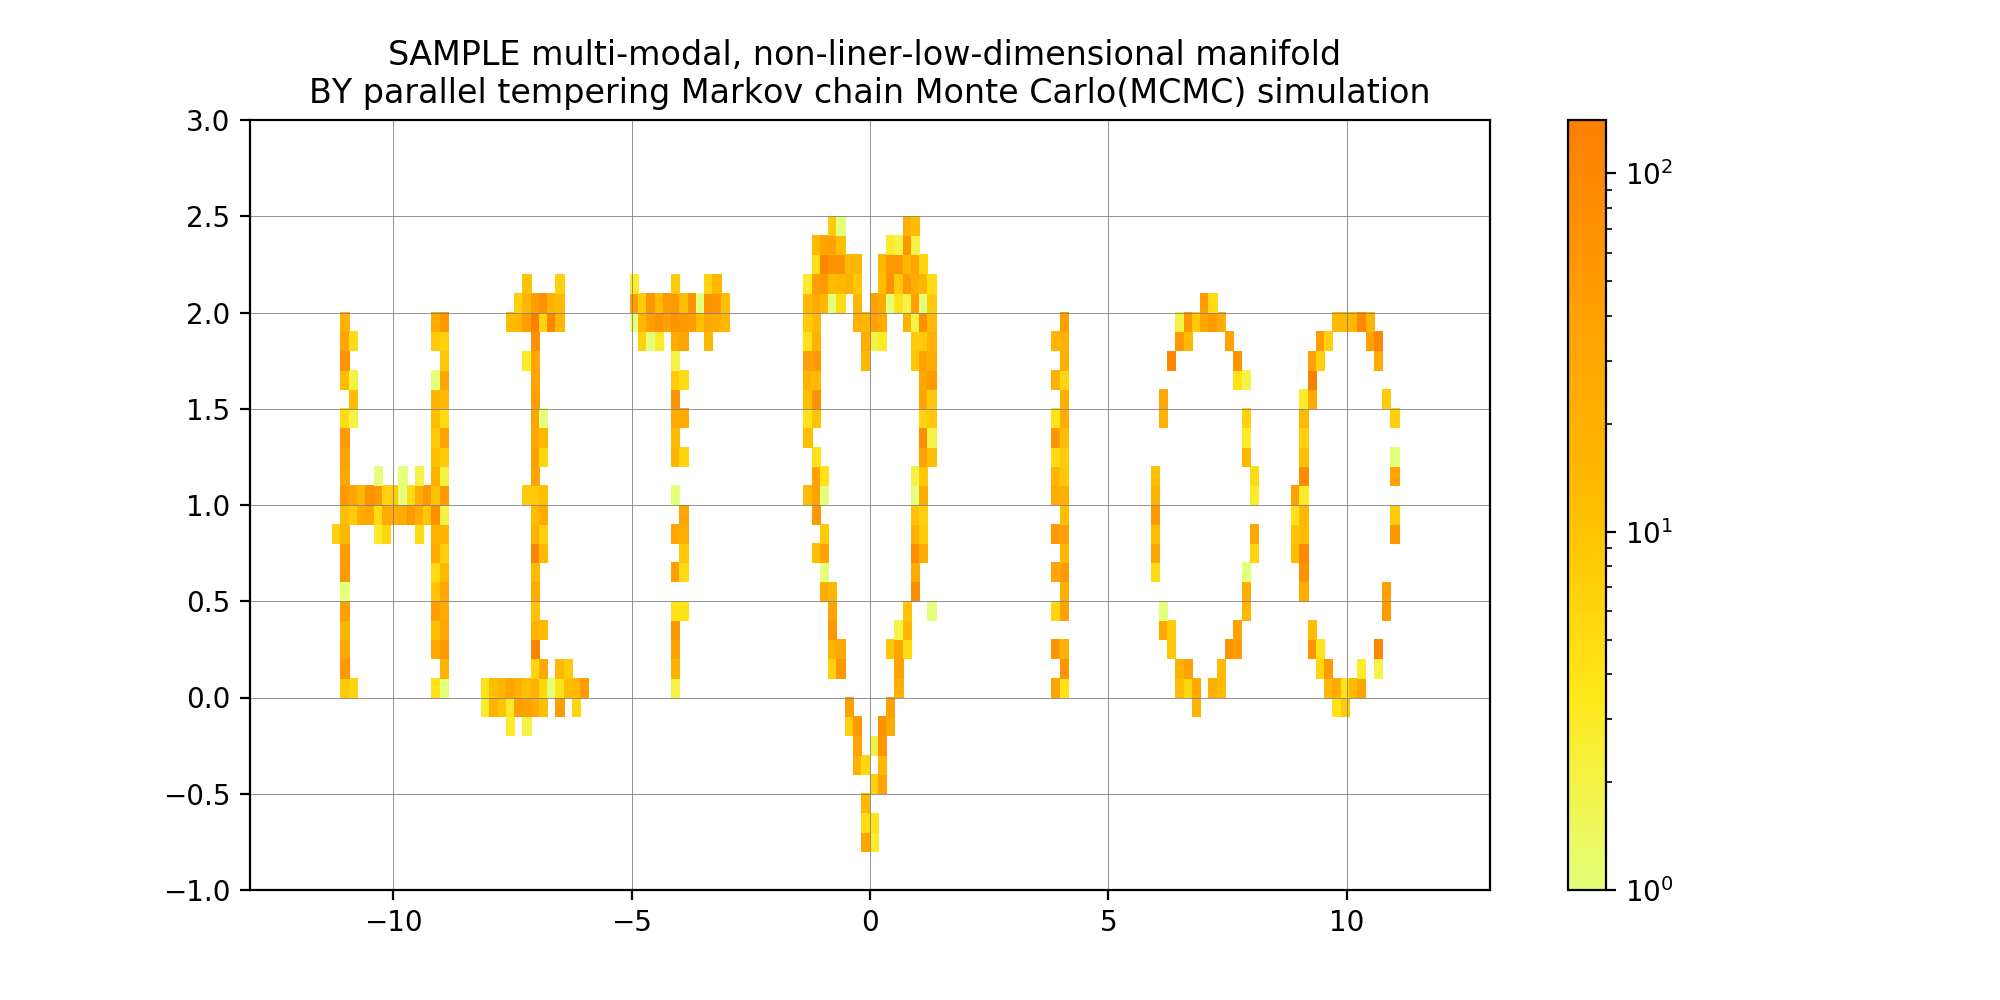

Text(0.5, 1.0, 'SAMPLE multi-modal, non-liner-low-dimensional manifold \nBY parallel tempering Markov chain Monte Carlo(MCMC) simulation')

In [18]:
xs = experiment_control.xs
# plot the histograms of samples
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
xmin, xmax = -13, 13
ymin, ymax = -1, 3
h = ax.hist2d(xs[:, 0], xs[:, 1], bins=[150, 40], norm=mcolors.LogNorm(),
                  range=[[xmin, xmax], [ymin, ymax]],  cmap='Wistia')
plt.grid()
plt.colorbar(h[3], ax=ax)
plt.grid(color='grey', linestyle='-', linewidth=0.3)
ax.set_title("SAMPLE multi-modal, non-liner-low-dimensional manifold " + '\nBY' + " parallel tempering Markov chain Monte Carlo(MCMC) simulation")

In [19]:
class demo_mcmc():
    def __init__(self, xs):
        self.xs = xs
    def animate_moving_cluster(self):
        def animate(i):
            plt.clf()
            ax = fig.add_subplot(1, 1, 1)    
            ax.set_title('num=%d' % (i*10))
            ax.set_xlim(-13, 13)
            ax.set_ylim(-1, 3)
            plt.grid(color='grey', linestyle='-', linewidth=0.3)
            ax.scatter(x=self.xs[:(i+1)*10,0], y=self.xs[:(i+1)*10,1], color="r", s=15)
        fig = plt.figure(figsize=(8,4))

        ani = animation.FuncAnimation(fig, animate, frames=int(self.xs.shape[0]/10), repeat=False, interval=1, cache_frame_data=False)
        return ani

In [ ]:
de = demo_mcmc(experiment_control.xs[2000:])
ani = de.animate_moving_cluster()

In [22]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=100, metadata=dict(artist='Huajian'), bitrate=9000)

ani.save('../im.mp4', writer=writer)

In [ ]:
ani.save('../animation.gif', writer='imagemagick', fps=1250)

## another example in exercise 3,4

In [ ]:
%run -i Project_ex3

In [3]:
xs = experiment_control.xs

In [ ]:
de = demo_mcmc(xs[2000:])
ani = de.animate_moving_cluster()

In [11]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=100, metadata=dict(artist='Huajian'), bitrate=9000)

ani.save('../csqi.mp4', writer=writer)